# Corpus and BGRF Composition

We describe and analyse the status quo of the corpus with respect to criteria like author gender, year of first publication, narrative form etc. Then we compare it to the "baseline" of the Bibliographie du genre romanesque français, 1751-1800 (BGRF).

**Table of Contents**
* [Prerequisites](#Prerequisites)
  - [Import](#Import-all-necessary-python-libraries)
  - [Load corpus Metadata](#Corpus-Metadata)
  - [BGRF Metadata from Wikibase](#BGRF-Metadata-from-Wikibase)
    - [Configuration](#Configuration)
    - [Data Loading](#Data-Loading)
* [Author Gender](#Author-gender)
  - [Author Gender corpus](#Author-Gender-Corpus)
  - [Author Gender BGRF](#Author-Gender-(BGRF))
  - [Comparison](#comparison-by-decades)
* [Publication Date](#Publication-date)
  - [Publication Date](#Year-of-first-publication)
  - [Publication Date](#Publication-Date-(BGRF))
  - [Comparison](#Publication-Date-(Corpus-vs-BGRF))
* [Narrative Form](#Narrative-Form)
  - [Narrative Form corpus](#Narrative-Form-corpus)
  - [Narrative Form](#Narrative-Form-(BGRF))
  - [Comparison](#Narrative-Form-(Corpus-vs-BGRF))

## Prerequisites

### Import all necessary python libraries

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
import seaborn as sns
sns.set()

# Install with e.g. `pip install sparqlwrapper`
from SPARQLWrapper import SPARQLWrapper, JSON

# Make plots appear directly in the notebook.
%matplotlib inline

from pprint import pprint

import gender_guesser.detector as gg
import re

### Corpus Metadata

Load the corpus metadata from the MiMoText-Github-page as DataFrame and show all metadata available as well as the number of novel files included in the metadata table.

In [84]:
# Adjust the URL to the .tsv file as needed.
DATA_URL = 'https://raw.githubusercontent.com/MiMoText/roman18/master/XML-TEI/xml-tei_full_metadata.tsv'
xml_tei_metadata = pd.read_csv(DATA_URL, sep='\t', encoding="utf8")
print('Available column names:', xml_tei_metadata.columns.values)
print("amount of texts in corpus: ", len(xml_tei_metadata))

Available column names: ['filename' 'au-name' 'au-birth' 'au-death' 'title' 'au-gender'
 'firsted-yr' 'printSource-yr' 'form' 'spelling' 'data-capture'
 'token count' 'size' 'bgrf' 'author_wikidata' 'title_wikidata' 'lang'
 'publisher' 'distributor' 'distribution_date' 'copyright_status'
 'digitalSource_Title' 'digitalSource_Ref' 'digitalSource_Publisher'
 'digitalSource_Date' 'printSource_title' 'printSource_author'
 'printSource_pubPlace' 'printSource_date' 'resp_datacapture'
 'resp_encoding']
amount of texts in corpus:  191


Some of the metadata is not necessary for the script, so we can drop those columns to size down the DataFrame a little bit.

In [85]:
xml_tei_metadata.drop(columns=['data-capture', 'lang', 'distributor','distribution_date', 'copyright_status','resp_datacapture', 'resp_encoding', 'au-birth', 'au-death', 'spelling', 'author_wikidata', 'title_wikidata', 'publisher', 'digitalSource_Title', 'digitalSource_Ref', 'digitalSource_Publisher', 'digitalSource_Date', 'printSource_title', 'printSource_author'], inplace=True)

print('Available column names:', xml_tei_metadata.columns.values)

Available column names: ['filename' 'au-name' 'title' 'au-gender' 'firsted-yr' 'printSource-yr'
 'form' 'token count' 'size' 'bgrf' 'printSource_pubPlace'
 'printSource_date']


As we have some data that does not match the BGRF criteria as the first publication date, we will drop those for better comparison. Some of the texts therefore don't have a BGRF-ID, so lets check for it and drop those.

In [86]:
print("Number of texts in corpus: ", len(xml_tei_metadata))
xml_tei_metadata = xml_tei_metadata.drop(xml_tei_metadata[(xml_tei_metadata["bgrf"] == "0") | (xml_tei_metadata["bgrf"] == "1")].index)
print("Number of texts that do have a bgrf-id: ", len(xml_tei_metadata))

xml_tei_metadata = xml_tei_metadata.sort_values(by=["bgrf"])

Number of texts in corpus:  191
Number of texts that do have a bgrf-id:  187


### BGRF Metadata from Wikibase
Data is pulled from the MiMoText-Wikibase.

#### Configuration

In [87]:
# Adjust these values whenever another Wikibase instance is to be used.
WB_URL = 'https://query.mimotext.uni-trier.de/'
ITEM_IDS = {
    'publication_date': 'P9',
    'author' : 'P5',
    'publication_date_str': 'P23',  # hard to use, since not normalized
    'narrative_form': 'P33',        
    'narrative_form_str': 'P27',    
    #'page_count': 'P34',            # the wikibase label is "number of pages"
    'page_count_str': 'P25',        # the wikibase label is "number of pages_string"
    'distribution_format_str': 'P26',
    #'distribution_format': 'P37',
    'bgrf_id': 'P22'
}

#### Data Loading

We use the SPARQL endpoint to query the bibliography metadata. Each metadatum gets its own query for simplicity's sake.

In [88]:
bgrf = pd.DataFrame()
wb_endpoint = f'{WB_URL}/proxy/wdqs/bigdata/namespace/wdq/sparql'

def get_data(endpoint, query):
    '''Given an endpoint URL and a SPARQL query, return
    the data as JSON.
    '''
    user_agent = 'jupyter notebook'
    sparql = SPARQLWrapper(endpoint, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()["results"]["bindings"]

This wrapper function conveniently provides the data as python dictionaries.
For example, to get all the data values for the property `narrative_form_str`,
we can use the following:


In [89]:
ex_query = 'prefix wd:<http://data.mimotext.uni-trier.de/entity/> prefix wdt:<http://data.mimotext.uni-trier.de/prop/direct/> SELECT DISTINCT ?form WHERE { ?item wdt:P27 ?form. }'
results = get_data(wb_endpoint, ex_query)
print('Number of distinct values:', len(results))
print('Each entry has the following form (NPI):', results[0])

Number of distinct values: 263
Each entry has the following form (NPI): {'form': {'xml:lang': 'fr', 'type': 'literal', 'value': '3e partie: Relation du voyage d’un sublunaire; 1re personne avec des récits d’autres voyageurs'}}


The key `'form'` corresponds to us choosing `?form` as the output variable in our SPARQL query.

In [90]:
# get the most important items from wikibase here
"""
# Query as it would be in sparql
SELECT ?authorLabel ?pubdate ?bgrf ?page_count ?narrLabel
WHERE {
  ?item wdt:P5 ?author; wdt:P7 ?pubdate; wdt:P13 ?bgrf.
  OPTIONAL { ?item wdt:P44 ?page_count; wdt:P54 ?narr.}
  SERVICE wikibase:label {bd:serviceParam wikibase:language "{AUTO_LANGUAGE}","en" .}}
"""
# Transformed to python
query_wikibase = ''.join([
    'prefix wd:<http://data.mimotext.uni-trier.de/entity/>',
    'prefix wdt:<http://data.mimotext.uni-trier.de/prop/direct/>', 
    'SELECT ?authorLabel ?year ?bgrf_id ?page_count ?narrLabel ',
    'WHERE {',
    '?item wdt:', ITEM_IDS['author'], ' ?author; wdt:', ITEM_IDS['publication_date'], ' ?pubdate; wdt:', ITEM_IDS['bgrf_id'], ' ?bgrf_id',
    ' BIND(YEAR(?pubdate) as ?year).', 
    'OPTIONAL { ?item wdt:', ITEM_IDS['page_count_str'], ' ?page_count.}',
    'OPTIONAL { ?item wdt:', ITEM_IDS['narrative_form'], ' ?narr.}',
    'SERVICE wikibase:label',
    '{bd:serviceParam wikibase:language "{AUTO_LANGUAGE}","en" .}}'
])
wikibase = get_data(wb_endpoint, query_wikibase)
wikibase_df = pd.json_normalize(wikibase)

Now we need to drop some of the unneccessary items like the language specifier.

In [91]:

wikibase_df.drop(columns=['page_count.xml:lang', 'page_count.type', 'bgrf_id.type', 'year.datatype', 'year.type','authorLabel.xml:lang',
    'authorLabel.type', 'narrLabel.xml:lang', 'narrLabel.type'], inplace=True)

wikibase_df.rename(columns={'year.value':"year", "bgrf_id.value": "bgrf"}, inplace=True)
wikibase_df["form"] = wikibase_df["narrLabel.value"]



#### Add additional data

In [92]:
# copy dataframes to leave them untouched if we want to use them later again
wikibase_data = wikibase_df.copy()
corpus = xml_tei_metadata.copy()

## add origin as column for combination later
corpus["origin"] = "corpus"
wikibase_data["origin"] = "wikibase"

As there is currently no gender information within the MiMoText-Wikibase, we are using the gender guesser. Some of the authors don't have a first name, which will lead to "unknown", others contain titles in their name like "baron" or "baronesse" which can be categorzied beforehand.

In [93]:
## Add gender to wikibase

# NOTE: currently no data for gender information in Wikibase, so we use the gender detector to get the genders.

dec = gg.Detector()
# get author gender based on the first name of the authors

wikibase_data["gender"] = ""
wikibase_data["prename_new"] = ""

# for gender-guesser we only need the prenam
for i, au in wikibase_data['authorLabel.value'].iteritems():
    try:
        prename = au
        prename = prename.strip()  #remove whitespaces
        if re.search("madame", prename) or re.search("mademoiselle", prename) or re.search("comtesse", prename) or re.search("baronne", prename) or re.search("marquise", prename):
            wikibase_data["prename_new"].loc[i] = prename
            wikibase_data["gender"].loc[i] = "female" 
        elif re.search("abbé", prename) or re.search("avocat", prename) or re.search("chevalier", prename) or re.search("baron", prename) or re.search("comte", prename) or re.search("marquis", prename) or re.search("père", prename) or re.search("duc", prename):
            wikibase_data["prename_new"].loc[i] = prename
            wikibase_data["gender"].loc[i] = "male" 
        else:
            prename = au.split(',')[1].split('-')[0]
            if re.search(" É", prename):
                prename = re.sub("É", "E", prename) # Étienne not in gg, but Etienne is
            prename = prename.replace("dom", "")
            prename = prename.strip()
            wikibase_data["prename_new"].loc[i] = prename
            if re.search(" de", prename) and len(list(prename.strip())) != 2:
                prename = prename.strip().split(" ")[0]
                wikibase_data["prename_new"].loc[i] = prename
            elif len(list(prename.strip())) == 2: #re.search("d’", prename) and 
                wikibase_data["gender"].loc[i] = "unknown"
            elif len(prename.strip().split(" ")) > 1:
                prename = prename.strip().split(" ")[0]
                wikibase_data["prename_new"].loc[i] = prename
    except IndexError:
        prename = au
        wikibase_data["prename_new"].loc[i] = prename
        wikibase_data["gender"].loc[i] = "unknown"

for i, au in wikibase_data.iterrows():
    if au["gender"] == "":
        gender = dec.get_gender(au["prename_new"].strip())
        wikibase_data["gender"].loc[i] = gender
    #print(gender)
wikibase_data["gender"] = wikibase_data["gender"].map(lambda x: "male" if x == "mostly_male" else x )
wikibase_data["gender"] = wikibase_data["gender"].map(lambda x: "unknown" if x == "andy" else x )
wikibase_data.drop(columns=["prename_new"], inplace=True)
print(wikibase_data["gender"].value_counts())
print("Number of rows in wikibase data: ", len(wikibase_data))

male       964
female     256
unknown    141
Name: gender, dtype: int64
Number of rows in wikibase data:  1361


Genders in the Metadata of the Corpus have the categories "F", "M" and "U" which are going to be changed to "female", "male" and "unknown".

In [94]:
# map F as female, M as male and U as unknown in corpus to match with detected String labels from gender detector
corpus["gender"] = corpus["au-gender"]
corpus["gender"] = corpus["gender"].map(lambda x: "female" if x == "F" else x)
corpus["gender"] = corpus["gender"].map(lambda x: "male" if x == "M" else x)
corpus["gender"] = corpus["gender"].map(lambda x: "unknown" if x == "U" else x)

### Combine wikidata and metadata-Table to one table

##### Choose year and Add decades

As not all dates of publication within the metadata and BGRF match exactly, you can choose whether to use the "firsted-yr" or the year based on the BGRF as first publication date.

In [95]:
## add year based on bgrf because it can differ from firsted-yr
# with only the first two digits of the bgrf which represent the years of the first publication
# if it does not have a bgrf we cast it as 1801

corpus["bgrf_year"] = corpus["bgrf"].map(lambda x: int(x.split(".")[0]) if x != "0" else 1)
corpus["bgrf_year"] = corpus["bgrf_year"].map(lambda x: 1700+x if x in range(50,100) else 1800+x)

# change dates to datetime-format
corpus["bgrf_year"] = pd.to_datetime(corpus['bgrf_year'], format='%Y')
corpus["firsted-yr"] = pd.to_datetime(corpus['firsted-yr'], format='%Y')

# print corpus
corpus

,filename,au-name,title,au-gender,firsted-yr,printSource-yr,form,token count,size,bgrf,printSource_pubPlace,printSource_date,origin,gender,bgrf_year
2,Anonym_Enfant,Anonyme,L'enfant du bordel,U,1800-01-01,1800,autodiegetic,31188,short,0.16,Paris,1800,corpus,unknown,1800-01-01
130,Pertusier_Premiere,Charles Pertusier,Mes premières étourderies,M,1800-01-01,AN VIII,epistolary,51089,medium,00.117,Paris,AN VIII,corpus,male,1800-01-01
131,PigaultLebrun_Adele,"Charles-Antoine-Guillaume Pigault de l’Epinay,...","Adèle et D'Abligny, par Pigault-Lebrun",M,NaT,1800,heterodiegetic,20215,short,00.119,Paris,1800,corpus,male,1800-01-01
134,PigaultLebrun_Metusko,"Charles-Antoine-Guillaume Pigault de l’Epinay,...","Métusko, ou les polonais",M,1800-01-01,1802,heterodiegetic,19289,short,00.120,NaN,1802,corpus,male,1800-01-01
133,PigaultLebrun_Kinglin,"Charles-Antoine-Guillaume Pigault de l’Epinay,...","Monsieur de Kinglin, ou la prescience",M,1800-01-01,1823,heterodiegetic,21942,short,00.122,Paris,1823,corpus,male,1800-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,Arnaud_Matinees,François-Thomas-Marie de Baculard d’Arnaud,Les matinées,M,1798-01-01,1799,heterodiegetic,76554,medium,99.43,Paris,1799,corpus,male,1799-01-01
30,Bellin_Nuit,Louis François Marie Bellin de La Liborlière,La Nuit anglaise,M,1799-01-01,1799,heterodiegetic,47089,short,99.44,Hambourg,1799,corpus,male,1799-01-01
55,Cottin_Claire,Sophie Cottin,Claire d’Albe,F,1798-01-01,1824,epistolary,40093,short,99.62,Paris,1824,corpus,female,1799-01-01
72,Ducray_Cinquante,François Guillaume Ducray-Duminil,Les Cinquante francs de Jeannette,M,1798-01-01,1798,heterodiegetic,72560,medium,99.76,Paris,1798,corpus,male,1799-01-01


Now let's check how many of the firsted-yr and the bgrf-year don't correlate:

In [96]:
not_machting_counter = 0
for i, row in corpus.iterrows():
    if row["firsted-yr"] != "nan" and row["firsted-yr"] != row["bgrf_year"]:
        not_machting_counter += 1
print("number of texts that don't have matching bgrf and firsted-yr first year publications: ", not_machting_counter)

number of texts that don't have matching bgrf and firsted-yr first year publications:  35


Choose whether to use the generated bgrf-year or the first publication year from the metadata table. As default the bgrf-year is chosen.

In [97]:
corpus["year"] = corpus["bgrf_year"] # or "firsted-yr"

Now we can combine the to dataframes.

In [98]:
wikibase_data["year"] = pd.to_datetime(wikibase_data["year"], format="%Y")

combined = pd.concat([corpus, wikibase_data], ignore_index=True)
combined = combined.drop(columns=["filename", "au-name", "title", "au-gender",  "authorLabel.value", "narrLabel.value"])


Next we can add decades based on the year.

In [99]:

decades_to_map = [(1750, 1759, "1750er"), (1760, 1769, "1760er"), (1770, 1779, "1770er"), (1780, 1789, "1780er"), (1790, 1799, "1790er"), (1800, "1800")]
for dec in decades_to_map:
    if len(dec) == 3:
        combined.loc[(combined["year"].dt.year.between(dec[0], dec[1])), "decade"] = dec[2]
    else:
        combined.loc[(combined["year"].dt.year==dec[0]), "decade"] = dec[1]

## Author Gender


### Author Gender Corpus
Data is in the column 'au-gender'. Possible values are 'F', 'M' and 'U'.

Set of all occuring values: {'F', 'M', 'U'}
Percent of all genders in corpus 
 M    0.797
F    0.176
U    0.027
Name: au-gender, dtype: float64
Percent of all genders in corpus 
 M    149
F     33
U      5
Name: au-gender, dtype: int64


Text(0, 0.5, 'Count in corpus')

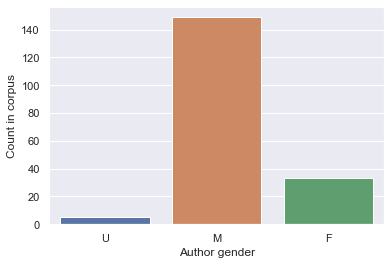

In [100]:
print('Set of all occuring values:', set(corpus["au-gender"].values))
print("Percent of all genders in corpus \n",corpus["au-gender"].value_counts(normalize=True).round(3))
print("Percent of all genders in corpus \n",corpus["au-gender"].value_counts().round(3))
## Visualization in total counts:
sns.countplot(x=corpus["au-gender"])
plt.xlabel('Author gender')
plt.ylabel('Count in corpus')

<AxesSubplot:xlabel='au-gender', ylabel='per'>

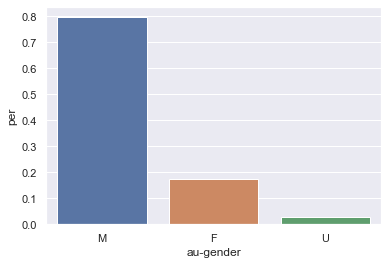

In [101]:
# Visualization in percent
corpus_gender_per = corpus["au-gender"].value_counts(normalize=True).round(3).reset_index()
corpus_gender_per.columns = ["au-gender", "per"]
sns.barplot(data=corpus_gender_per, x="au-gender", y="per")

### Author Gender (Wikibase)


    gender    per
0     male  0.708
1   female  0.188
2  unknown  0.104


Text(0, 0.5, 'Percent in wikidata')

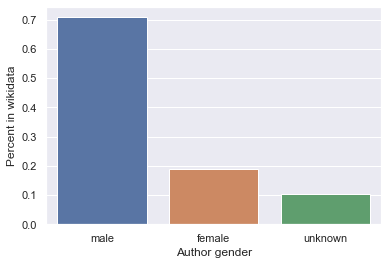

In [102]:
wikibase_gender_per = wikibase_data["gender"].value_counts(normalize=True).round(3).reset_index()
wikibase_gender_per.columns = ["gender", "per"]

print(wikibase_gender_per)
sns.barplot(data=wikibase_gender_per, x="gender", y="per")
plt.xlabel('Author gender')
plt.ylabel('Percent in wikidata')


### Comparison

#### Comparison of gender proportion in corpus and in wikibase


Text(0, 0.5, 'proportion')

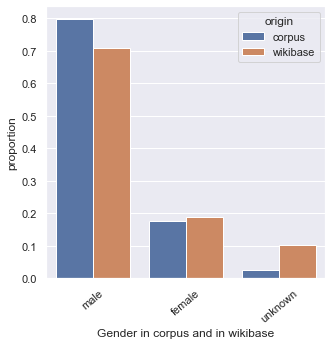

In [103]:

authors_grouped = combined.groupby(["origin"])["gender"].value_counts(normalize=True).reset_index(name="percentage")

fig, ax = plt.subplots(figsize=(5,5))
ax = sns.barplot(x="gender", y="percentage", hue="origin", data=authors_grouped)
plt.xticks(rotation=40)
plt.xlabel("Gender in corpus and in wikibase")
plt.ylabel("proportion")

We can see that the "unknown" annotated genders in the wikibase is quite high; that results of many authors that do not have a prename or a title like "comte" or "comtesse" which we covered in the previous part.
So for a "better" comparison we could remove all unknown gender data. This we will do in the following part where the genders will be compared within the decades.

#### Comparison by decades

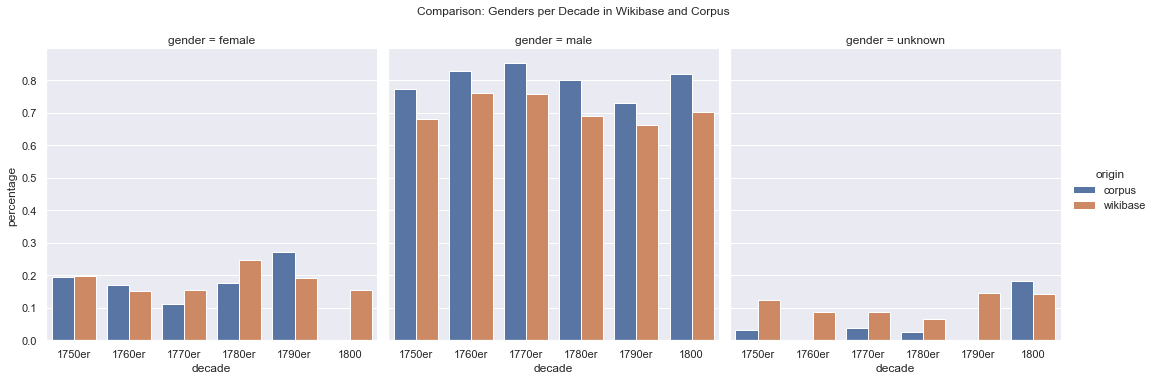

In [104]:
authors_decades = combined[["origin", "decade", "gender"]].groupby(["origin", "decade"]).value_counts(normalize=True, sort=False).reset_index(name="percentage")

# plot the data
sns.catplot(x="decade", y="percentage", hue="origin", col="gender", data=authors_decades, kind="bar")
plt.suptitle("Comparison: Genders per Decade in Wikibase and Corpus", y=1.05)
fig.tight_layout()


As we can see, the "unknown" gender in the xml-tei-corpus is so small that it is not quite visible in the visualization. Also the gender in the wikibase is based on the gender-guesser who cannot map all of the authors' names (e.g. only surnames etc.).
So in the following visualization we will drop the "unknown".

Text(0.5, 1.05, 'Comparison: Genders per Decade in Wikibase and Corpus without unknown gender')

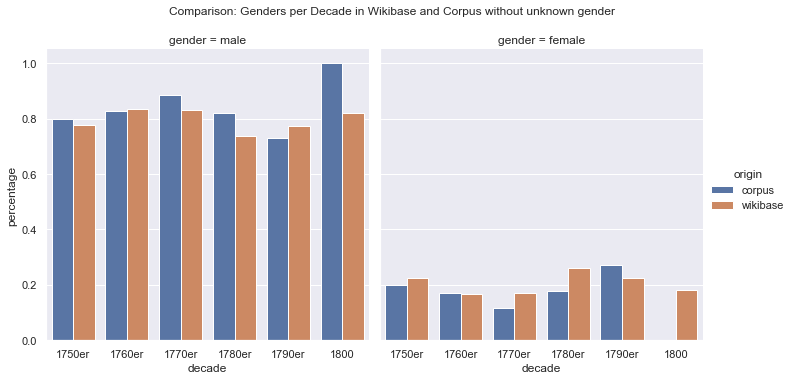

In [105]:
authors_wo_unknown = combined.drop(combined[(combined["gender"] == "unknown")].index)

authors_wo_unknown = authors_wo_unknown[["origin", "decade", "gender"]].groupby(["origin", "decade"]).value_counts(normalize=True).reset_index(name="percentage")
sns.catplot(x="decade", y="percentage", hue="origin", col="gender", data=authors_wo_unknown, kind="bar")
plt.suptitle("Comparison: Genders per Decade in Wikibase and Corpus without unknown gender", y=1.05)

## Publication Date

### Corpus Year of first publication
Data is in the column 'firsted-yr'. However, possible values can be single years `(yyyy)`, year spans `(yyyy-yyyy)`, the floating point number value `NaN`, or even a string like `'unknown'`. Therefore, we need to clean up a bit before we can use it. In case of year ranges, we simply use the first year.

If we run the cell below, we can check the first edition year and the bgrf numbers, where we will see that they differ a little bit, which can be caused by different sources of the first year information. Also there are few texts in the corpus that are not listed in the Bibliographie as novels, but we considered as interesting. For comparison though we will drop those now.

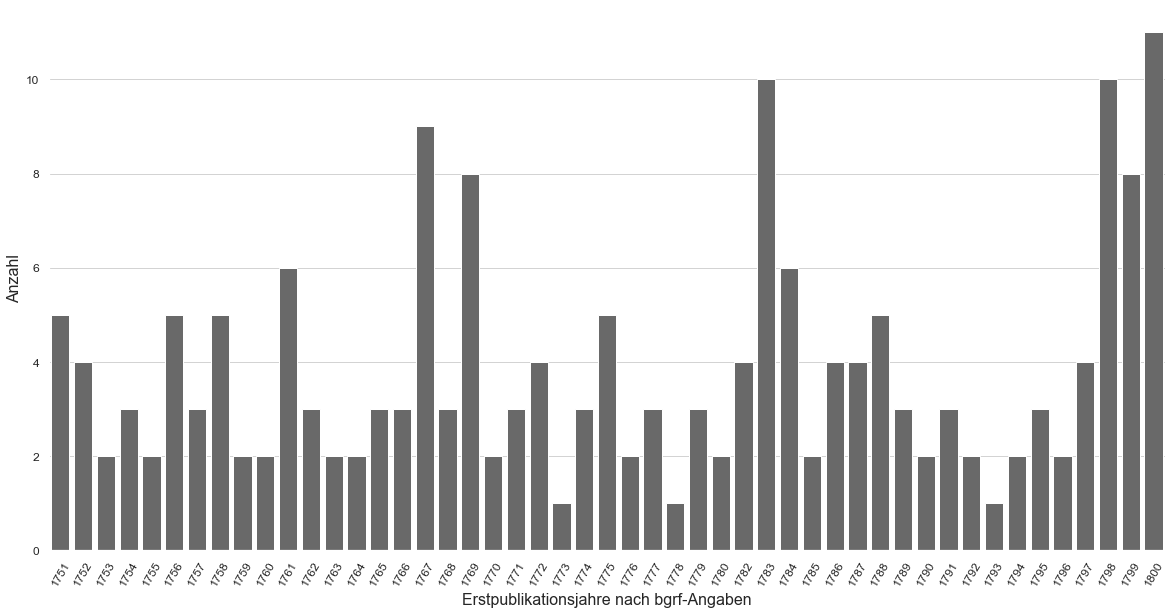

In [106]:
## Visualization of first year of publication in metadata

## Erstpublikation nach firsted-yr
firsted_corpus_sorted_yr = corpus["firsted-yr"].dt.year
firsted_corpus_sorted_yr = firsted_corpus_sorted_yr.drop(index=list(firsted_corpus_sorted_yr[firsted_corpus_sorted_yr=="nan"].index)).sort_values()

## Erstpublikation nach bgrf-Angabe in metadaten:
firsted_corpus_sorted_bgrf = corpus["bgrf_year"].dt.year.sort_values()
firsted_corpus_sorted_bgrf = firsted_corpus_sorted_bgrf.drop(index=list(firsted_corpus_sorted_bgrf[firsted_corpus_sorted_bgrf==1801].index)).sort_values()

def get_countplot_first_pub(df, col):

    fig, ax = plt.subplots(figsize=(20,10))

    sns.countplot(x=df, color="dimgrey")
    ax.set_facecolor(color="white")
    plt.xticks(rotation = 60, fontsize=12)
    plt.yticks(fontsize=12)
 
    plt.ylabel("Anzahl", fontsize=16)
    plt.grid(color="lightgrey", axis='y')

    if col == "bgrf":
        plt.xlabel("Erstpublikationsjahre nach bgrf-Angaben", fontsize=16)
    else:
        plt.xlabel("Erstpublikationsjahre nach firsted-yr", fontsize=16)
    #plt.savefig("Erstpublikationsjahre_grey.png", dpi=300)
#get_countplot_first_pub(firsted_corpus_sorted_yr, "first-yr")
get_countplot_first_pub(firsted_corpus_sorted_bgrf, "bgrf")

#### Visualization of publication year in corpus

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]),
 [Text(0, 0, '1751'),
  Text(1, 0, '1752'),
  Text(2, 0, '1753'),
  Text(3, 0, '1754'),
  Text(4, 0, '1755'),
  Text(5, 0, '1756'),
  Text(6, 0, '1757'),
  Text(7, 0, '1758'),
  Text(8, 0, '1759'),
  Text(9, 0, '1760'),
  Text(10, 0, '1761'),
  Text(11, 0, '1762'),
  Text(12, 0, '1763'),
  Text(13, 0, '1764'),
  Text(14, 0, '1765'),
  Text(15, 0, '1766'),
  Text(16, 0, '1767'),
  Text(17, 0, '1768'),
  Text(18, 0, '1769'),
  Text(19, 0, '1770'),
  Text(20, 0, '1771'),
  Text(21, 0, '1772'),
  Text(22, 0, '1773'),
  Text(23, 0, '1774'),
  Text(24, 0, '1775'),
  Text(25, 0, '1776'),
  Text(26, 0, '1777'),
  Text(27, 0, '1778'),
  Text(28, 0, '1779'),
  Text(29, 0, '1780'),
  Text(30, 0, '1782'),
  Text(31, 0, '1783'),
  Text(32, 0, '1784'),
  Text(33, 0, '1785'),
  Text

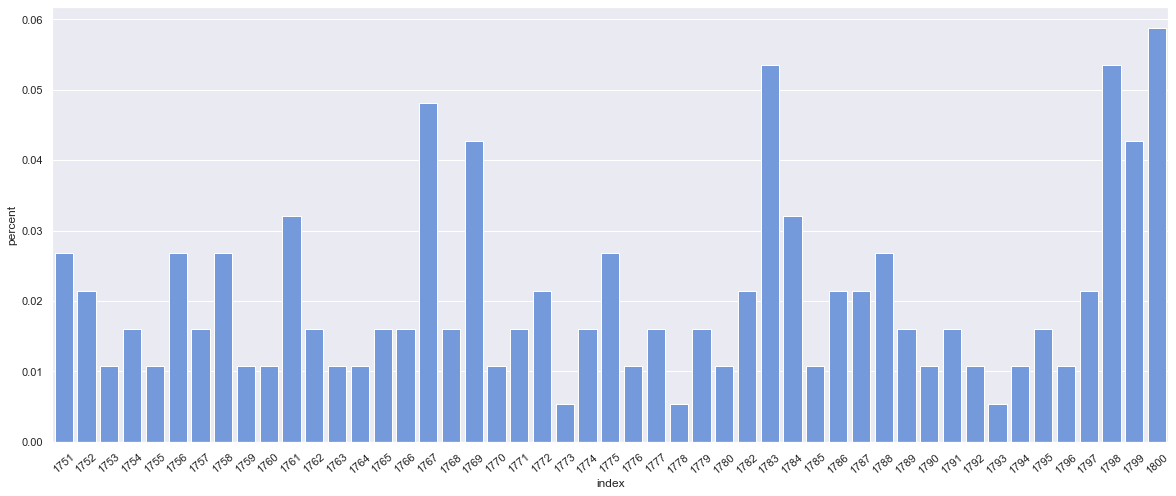

In [107]:
fig, ax = plt.subplots(figsize=(20,8))

bgrf_year_corpus = combined[combined["origin"]=="corpus"]["bgrf_year"].dt.year
bgrf_year_corpus = bgrf_year_corpus.value_counts(normalize=True).reset_index(name="percent")
bgrf_year_corpus
plot = sns.barplot(x=bgrf_year_corpus["index"], y=bgrf_year_corpus["percent"], color="cornflowerblue")
plt.xticks(rotation=40)


### Publication Date (Wikibase)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 [Text(0, 0, '1751'),
  Text(1, 0, '1752'),
  Text(2, 0, '1753'),
  Text(3, 0, '1754'),
  Text(4, 0, '1755'),
  Text(5, 0, '1756'),
  Text(6, 0, '1757'),
  Text(7, 0, '1758'),
  Text(8, 0, '1759'),
  Text(9, 0, '1760'),
  Text(10, 0, '1761'),
  Text(11, 0, '1762'),
  Text(12, 0, '1763'),
  Text(13, 0, '1764'),
  Text(14, 0, '1765'),
  Text(15, 0, '1766'),
  Text(16, 0, '1767'),
  Text(17, 0, '1768'),
  Text(18, 0, '1769'),
  Text(19, 0, '1770'),
  Text(20, 0, '1771'),
  Text(21, 0, '1772'),
  Text(22, 0, '1773'),
  Text(23, 0, '1774'),
  Text(24, 0, '1775'),
  Text(25, 0, '1776'),
  Text(26, 0, '1777'),
  Text(27, 0, '1778'),
  Text(28, 0, '1779'),
  Text(29, 0, '1780'),
  Text(30, 0, '1781'),
  Text(31, 0, '1782'),
  Text(32, 0, '1783'),
  Text(33, 0, '1784'),
  

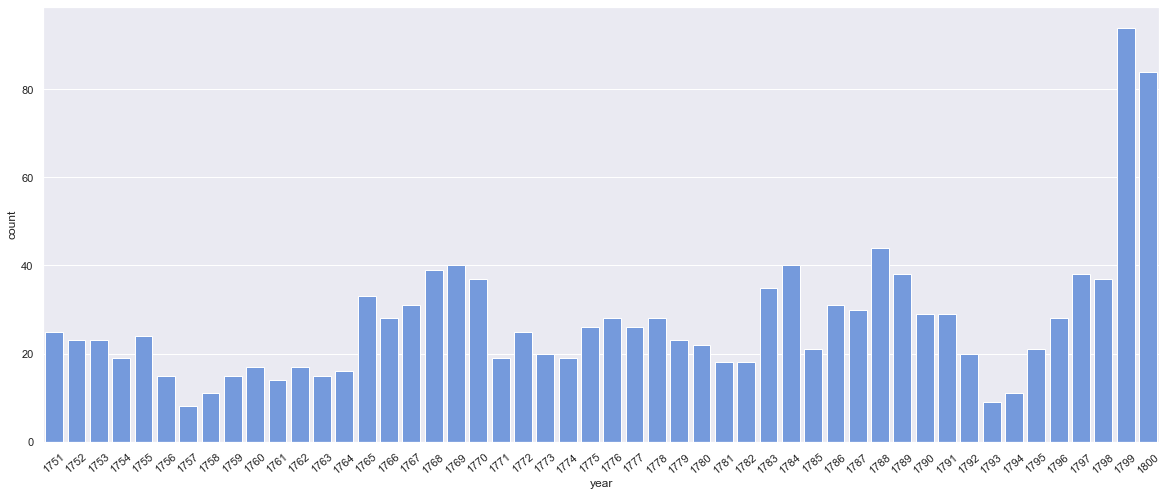

In [108]:
# Publication date
fig, ax = plt.subplots(figsize=(20,8))
plot = sns.countplot(x=combined[combined["origin"] == "wikibase"]["year"].dt.year, color="cornflowerblue")
plt.xticks(rotation=40)

### Comparison Publication Date

In [109]:
# Publication year of corpus texts:
year_corpus = combined[combined["origin"] == "corpus"]['firsted-yr']
# Publication year of BGRF items:
year_wikibase = combined[combined["origin"] == "wikibase"]['year']

# Create a date index which includes the whole data range
# so that we can fill in missing data points.
idx = pd.date_range(start='1740', end='1800', freq='YS', closed=None)

# In previous visualizations we have used absolute value counts.
# For comparison we obviously need to use relative frequencies instead.
df = pd.DataFrame(index=idx)
df['freq_corpus'] = year_corpus.value_counts(normalize=True)
print(df)
df['freq_bgrf'] = year_wikibase.value_counts(normalize=True)
df['year'] = df.index.year
print('The data in "wide form"\n', df.head(4), '\n')

# For the visualization we need the data in "long form", i.e. all the
# relative frequencies are in one single column, with another column 
# specifying whether it stems from the corpus or the bibliography.
long = pd.melt(
    df, id_vars=['year'], value_vars=['freq_corpus', 'freq_bgrf'],
    var_name='origin', value_name='rel_freq')

print('The data in "long form"\n', long.head(4))

            freq_corpus
1740-01-01          NaN
1741-01-01          NaN
1742-01-01          NaN
1743-01-01          NaN
1744-01-01          NaN
...                 ...
1796-01-01     0.026882
1797-01-01     0.010753
1798-01-01     0.048387
1799-01-01     0.032258
1800-01-01     0.048387

[61 rows x 1 columns]
The data in "wide form"
             freq_corpus  freq_bgrf  year
1740-01-01          NaN        NaN  1740
1741-01-01          NaN        NaN  1741
1742-01-01          NaN        NaN  1742
1743-01-01          NaN        NaN  1743 

The data in "long form"
    year       origin  rel_freq
0  1740  freq_corpus       NaN
1  1741  freq_corpus       NaN
2  1742  freq_corpus       NaN
3  1743  freq_corpus       NaN


C:\Users\Administrator\AppData\Local\Temp\ipykernel_15624\609836044.py:8: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  idx = pd.date_range(start='1740', end='1800', freq='YS', closed=None)


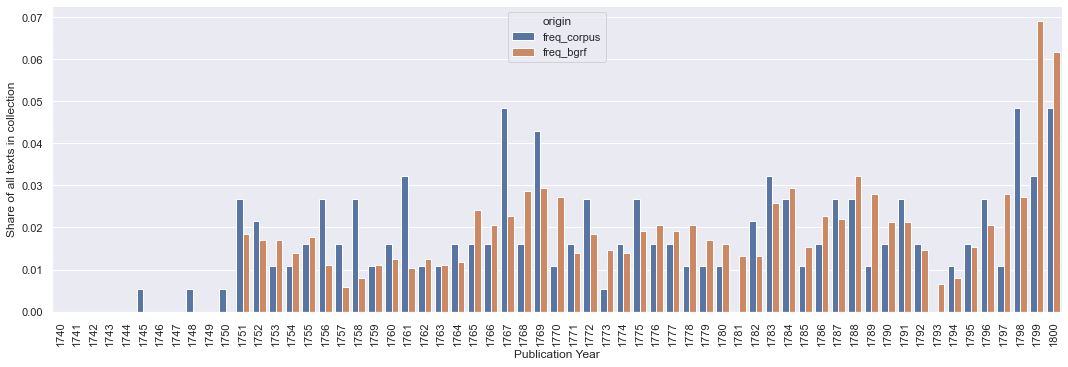

In [110]:
sns.catplot(x='year', y='rel_freq', hue='origin', kind='bar', data=long, height=5, aspect=3, legend_out=False)
plt.xlabel('Publication Year')
plt.ylabel('Share of all texts in collection')
_ = plt.xticks(rotation=90)

The outlier with publication year 1745 makes the above chart a bit harder to read than necessary. So let's create the same graph with data starting at 1751.

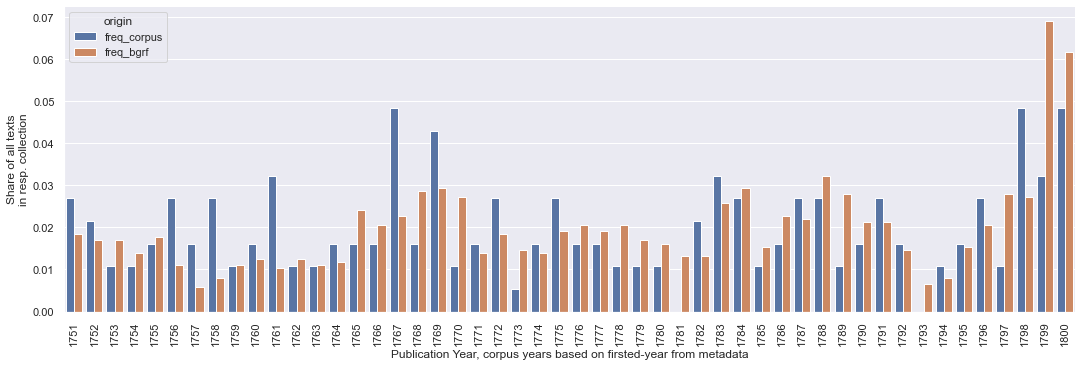

In [111]:
sns.catplot(x='year', y='rel_freq', hue='origin', kind='bar', data=long[long['year'] > 1750], height=5, aspect=3,
           legend_out=False)
plt.xlabel('Publication Year, corpus years based on firsted-year from metadata')
plt.ylabel('Share of all texts\nin resp. collection')
_ = plt.xticks(rotation=90)

Comparison of publication years based on year created on bgrf.

Text(0, 0.5, 'percent')

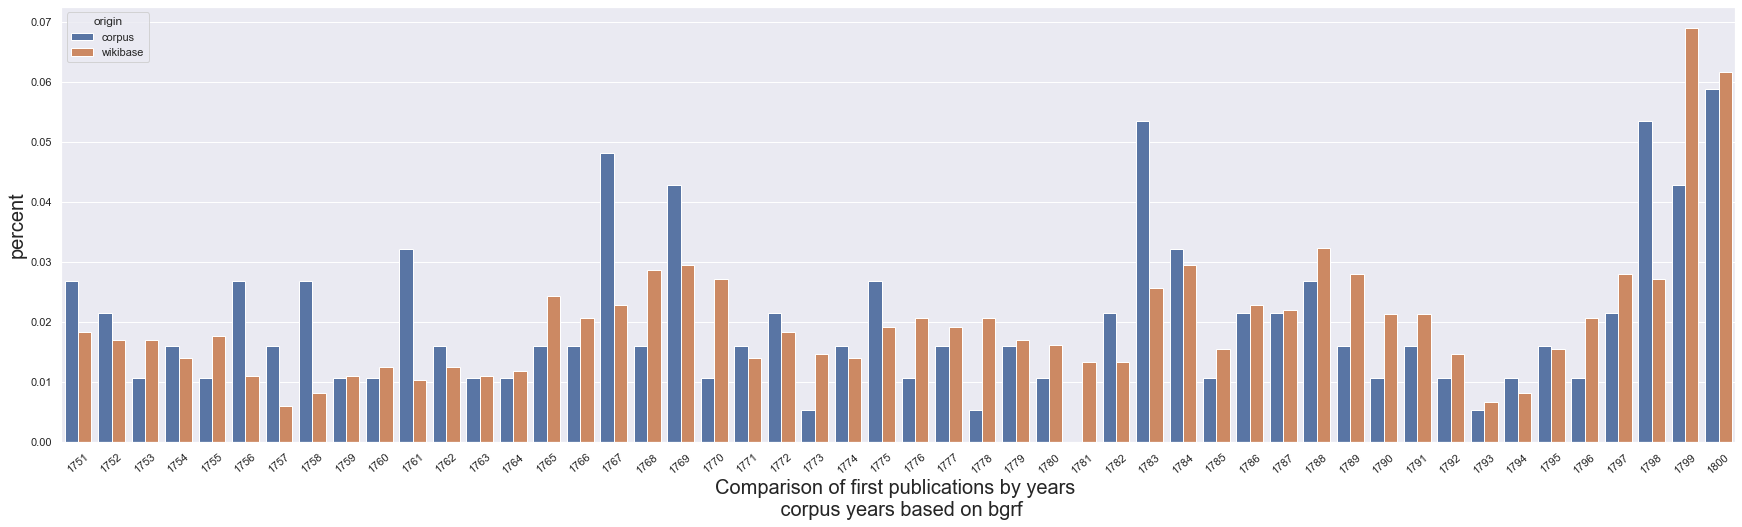

In [119]:

pubyears = combined[["origin", "year"]]
pubyears = pubyears.drop(pubyears[pubyears["year"] == 1801].index)
pubyears_grouped = pubyears.groupby(["origin"]).value_counts(normalize=True).reset_index(name="percentage")

# sort for years for visualization
years = sorted(set(pubyears["year"].dt.year))
fig, ax = plt.subplots(figsize=(30,8))
ax = sns.barplot(x=pubyears_grouped["year"].dt.year, y=pubyears_grouped["percentage"], hue="origin", data=pubyears_grouped, order = years)
plt.xticks(rotation=40)
plt.xlabel("Comparison of first publications by years \n corpus years based on bgrf", fontsize=20)
plt.ylabel("percent", fontsize=20)

## Narrative Form

### Narrative form corpus
Data is in the column 'form'. Possible values include `'mixed'`, `'autodiegetic'`, `'heterodiegetic'`, `'homodiegetic'`, `'epistolary'`, `'dialogue novel'` and also `NaN`.

Set of all values:  {'autodiegetic', 'unknown', 'heterodiegetic', 'homodiegetic', 'mixed', 'epistolary', 'dialogue novel'}
% of mixed: 	0.048
% of autodiegetic: 	0.246
% of heterodiegetic: 	0.444
% of homodiegetic: 	0.021
% of epistolary: 	0.198
% of dialogue novel: 	0.032


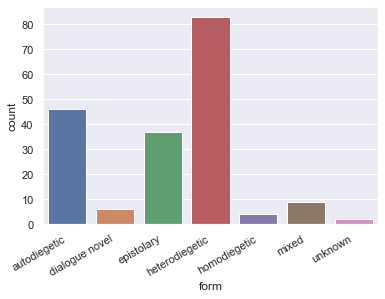

In [120]:
form = corpus['form'].astype('category')
print('Set of all values: ', set(form.values))
print('\n'.join([
    f'% of {kind}: \t{((form==kind).sum()/form.count()):.3f}'
    for kind in [
        'mixed', 'autodiegetic', 'heterodiegetic', 'homodiegetic',
        'epistolary', 'dialogue novel'
    ]
]))
plot = sns.countplot(x=form)
_ = plt.xticks(rotation=30, horizontalalignment='right')

### Narrative Form (Wikibase)

In the wikibase data some of the narrative forms are written a little different like dialogue novel vs. dialugue. In order to compare both the Wikibase-Data and the Metadata we will have to align those.

In [121]:
combined["form"] = combined["form"].map(lambda x: "dialogue novel" if x == "dialogue" else x)
print(combined.groupby(["origin", "form"])["form"].count())

origin    form          
corpus    autodiegetic       46
          dialogue novel      6
          epistolary         37
          heterodiegetic     83
          homodiegetic        4
          mixed               9
          unknown             2
wikibase  autodiegetic      290
          dialogue novel      6
          epistolary        171
          heterodiegetic    505
          homodiegetic       12
Name: form, dtype: int64


Plot narrative forms from Wikibase.

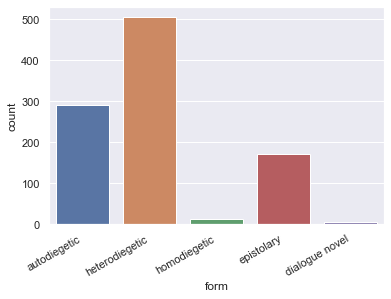

In [124]:
narrform_bgrf = combined[combined["origin"] == "wikibase"]["form"].reset_index()
plot = sns.countplot(x=narrform_bgrf['form'])
_ = plt.xticks(rotation=30, horizontalalignment='right')

## Comparison

### Narrative Form (Corpus vs BGRF)

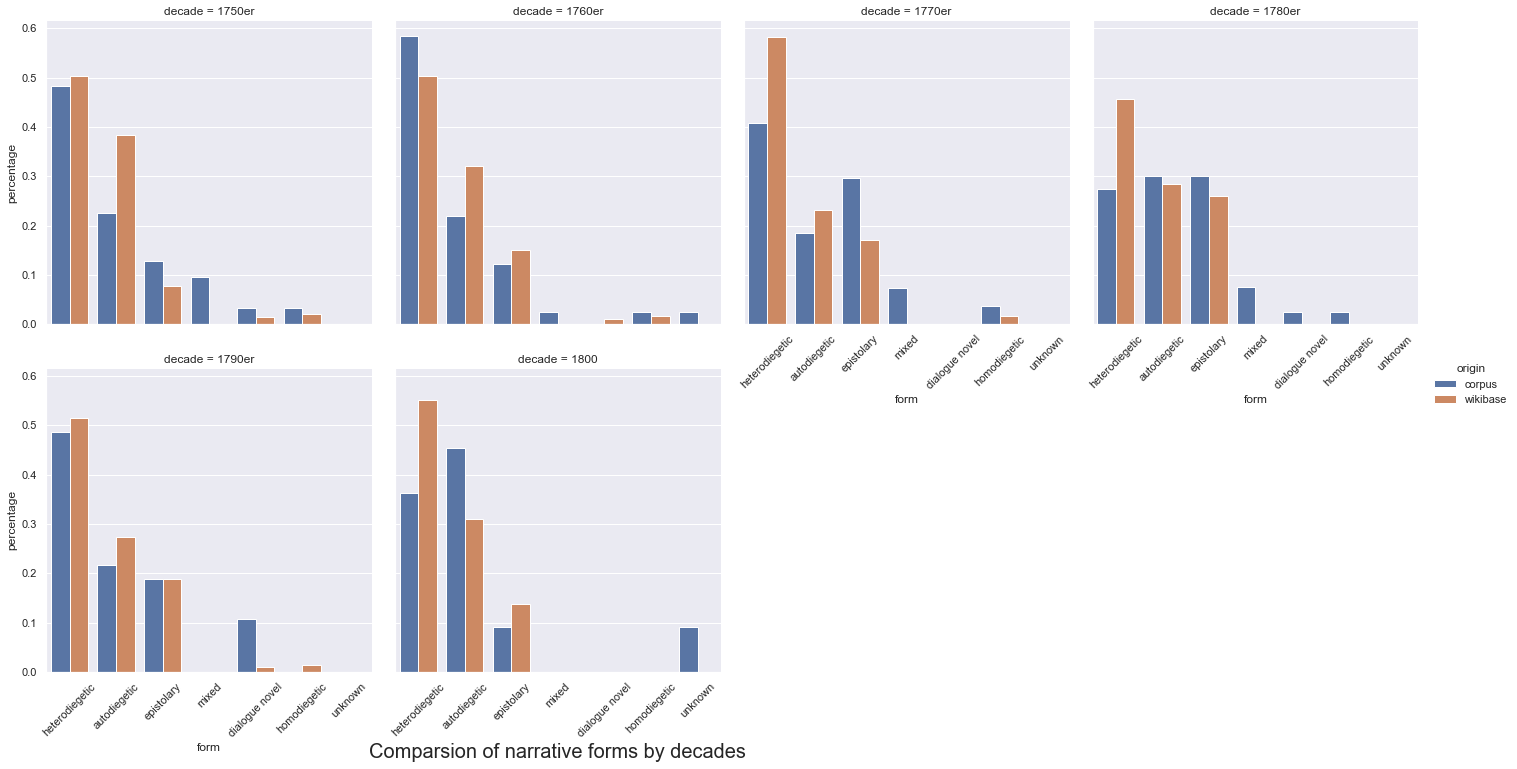

In [125]:
## comparison of the narrative forms by decade

narr_form_grouped = combined[["origin", "decade", "form"]].groupby(["origin", "decade"]).value_counts(normalize=True).reset_index(name="percentage")

ax = sns.catplot(x="form", y="percentage", col="decade", hue="origin", col_wrap=4, data=narr_form_grouped, kind="bar")
plt.xticks(rotation=90)
plt.xlabel("Comparsion of narrative forms by decades", fontsize=20)
plt.ylabel("percentage", fontsize=20)
ax.set_xticklabels(rotation=45)

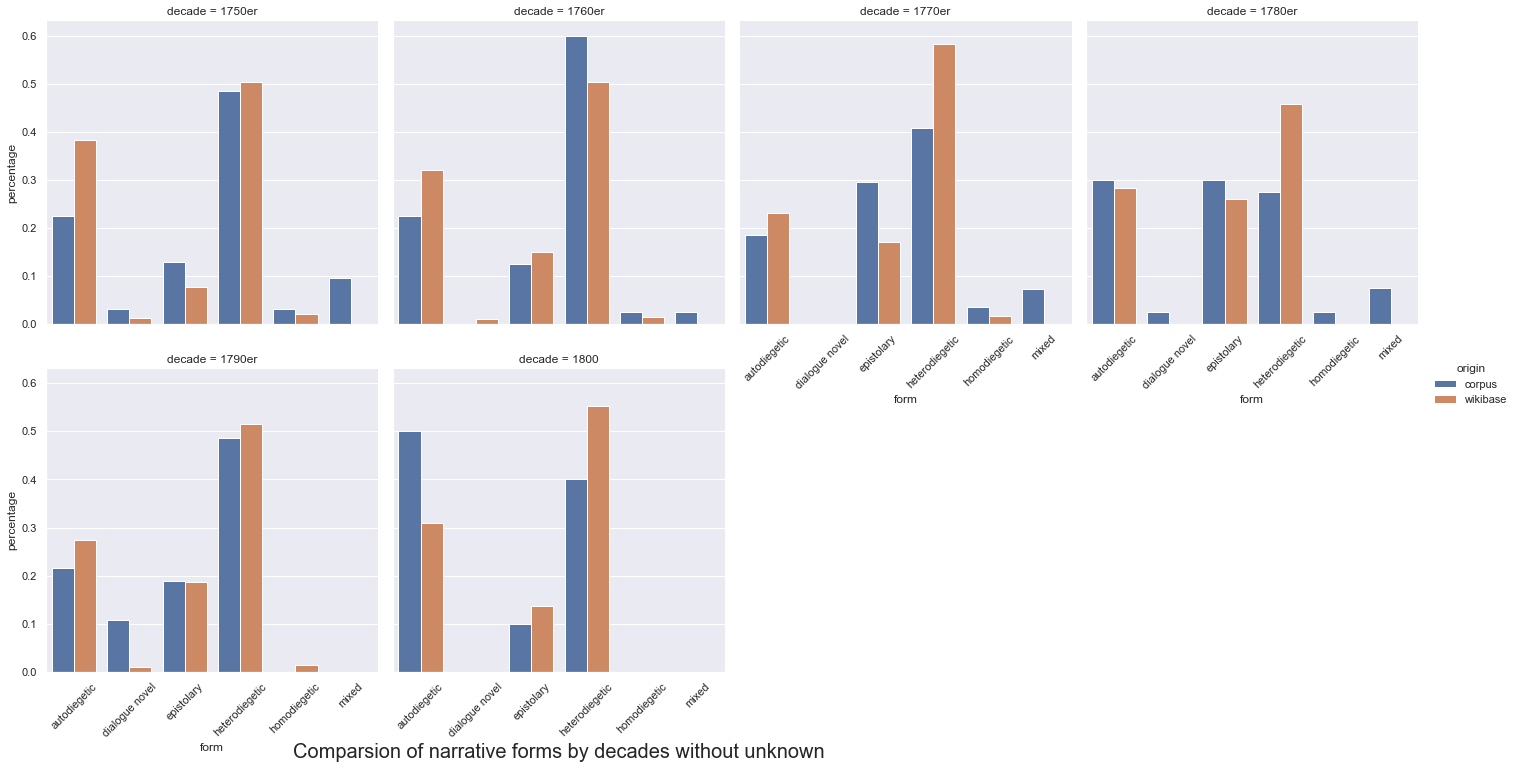

In [127]:
## drop unknown:
narr_form_combined = combined[["form", "decade", "origin"]]
narr_form_combined_wo_unknown = narr_form_combined.drop(narr_form_combined[(narr_form_combined["form"] == "unknown")].index)

narr_form_grouped_wo_unknwon = narr_form_combined_wo_unknown[["origin", "decade", "form"]].groupby(["origin", "decade"]).value_counts(normalize=True, sort=False).reset_index(name="percentage")

ax = sns.catplot(x="form", y="percentage", col="decade", hue="origin",col_wrap=4, data=narr_form_grouped_wo_unknwon, kind="bar")
plt.xticks(rotation=90)
plt.xlabel("Comparsion of narrative forms by decades without unknown", fontsize=20)
plt.ylabel("percentage", fontsize=20)
ax.set_xticklabels(rotation=45)

Narrative forms by gender in corpus

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'autodiegetic'),
  Text(1, 0, 'dialogue novel'),
  Text(2, 0, 'epistolary'),
  Text(3, 0, 'heterodiegetic'),
  Text(4, 0, 'mixed'),
  Text(5, 0, 'unknown'),
  Text(6, 0, 'homodiegetic')])

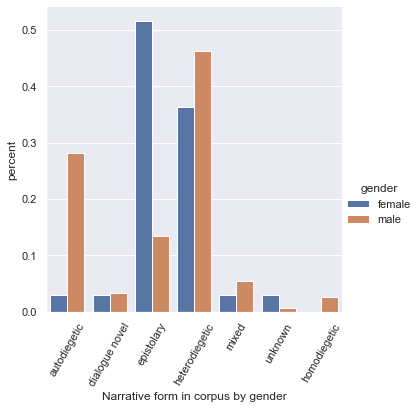

In [129]:
authors_narr_grouped = combined[combined["origin"] == "corpus"][["form", "gender"]]

authors_narr_grouped = authors_narr_grouped.drop(authors_narr_grouped[(authors_narr_grouped["gender"] == "unknown")].index)

authors_narr_grouped = authors_narr_grouped.groupby(["gender"]).value_counts(normalize=True, sort=False).reset_index(name="percent")


ax = sns.catplot(x="form", y="percent",  hue="gender", data=authors_narr_grouped, kind="bar")
plt.xlabel("Narrative form in corpus by gender")
plt.xticks(rotation=60)

Narrative forms by gender in wikibase

   gender            form   percent
0  female  heterodiegetic  0.505319
1  female      epistolary  0.329787
2  female    autodiegetic  0.148936
3  female    homodiegetic  0.010638
4  female  dialogue novel  0.005319
5    male  heterodiegetic  0.523460
6    male    autodiegetic  0.322581
7    male      epistolary  0.136364
8    male    homodiegetic  0.010264
9    male  dialogue novel  0.007331


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'heterodiegetic'),
  Text(1, 0, 'epistolary'),
  Text(2, 0, 'autodiegetic'),
  Text(3, 0, 'homodiegetic'),
  Text(4, 0, 'dialogue novel')])

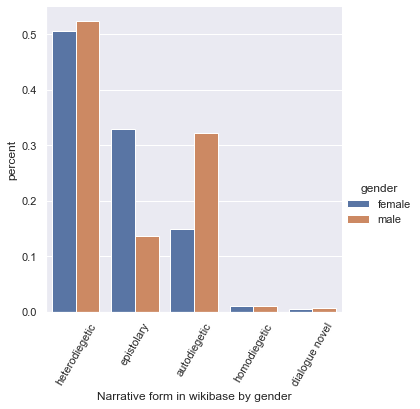

In [130]:
authors_narr_grouped_w = combined[combined["origin"] == "wikibase"][["form", "gender"]]

authors_narr_grouped_w = authors_narr_grouped_w.drop(authors_narr_grouped_w[(authors_narr_grouped_w["gender"] == "unknown")].index)

authors_narr_grouped_w = authors_narr_grouped_w.groupby(["gender"]).value_counts(normalize=True).reset_index(name="percent")
print(authors_narr_grouped_w)

ax = sns.catplot(x="form", y="percent",  hue="gender", data=authors_narr_grouped_w, kind="bar")
plt.xlabel("Narrative form in wikibase by gender")
plt.xticks(rotation=60)

### Narrative Form: Author gender wikibase and corpus comparison

Text(0.5, 0.98, 'Narrative form in corpus and wikibase by gender')

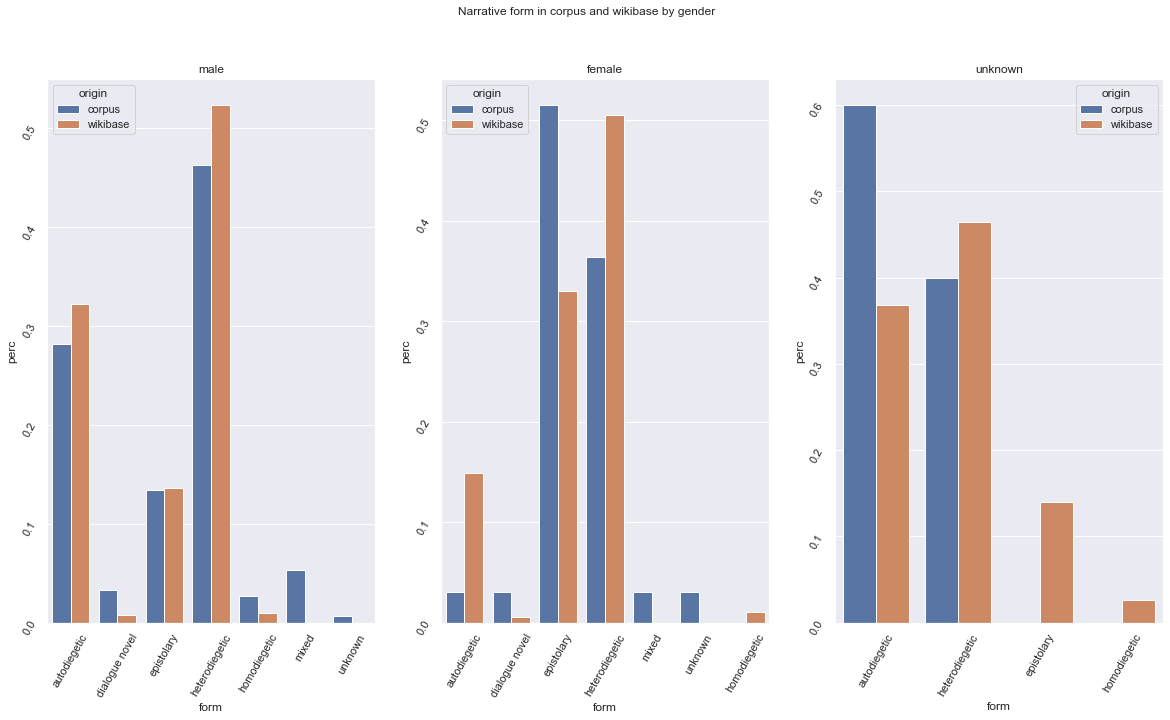

In [131]:
authors_gender_narr = combined[["gender", "origin", "form"]]
authors_gender_narr_grouped = authors_gender_narr[["origin", "form", "gender"]].groupby(["origin", "gender"]).value_counts(normalize=True, sort=False).reset_index(name="perc")

fig, axes = plt.subplots(1,3, figsize=(20,10))
ax1 = sns.barplot(x="form", y="perc",  hue="origin", data=authors_gender_narr_grouped[authors_gender_narr_grouped["gender"] == "male"], ax=axes[0])
axes[0].set_title("male")
ax2 = sns.barplot(x="form", y="perc",  hue="origin", data=authors_gender_narr_grouped[authors_gender_narr_grouped["gender"] == "female"], ax=axes[1])
axes[1].set_title("female")
ax3 = sns.barplot(x="form", y="perc",  hue="origin", data=authors_gender_narr_grouped[authors_gender_narr_grouped["gender"] == "unknown"], ax=axes[2])
axes[2].set_title("unknown")
#axes.xlabel("Narrative form in corpus and wikibase by gender")
for ax in fig.axes:
    ax.tick_params(rotation=60)
fig.suptitle("Narrative form in corpus and wikibase by gender")

Same plot, but without the unknown gender.

      gender    origin            form
1       male    corpus      epistolary
2       male    corpus  heterodiegetic
3       male    corpus  heterodiegetic
4       male    corpus  heterodiegetic
5       male    corpus    autodiegetic
...      ...       ...             ...
1541    male  wikibase  heterodiegetic
1542    male  wikibase             NaN
1544    male  wikibase    autodiegetic
1545    male  wikibase    autodiegetic
1547  female  wikibase             NaN

[1402 rows x 3 columns]


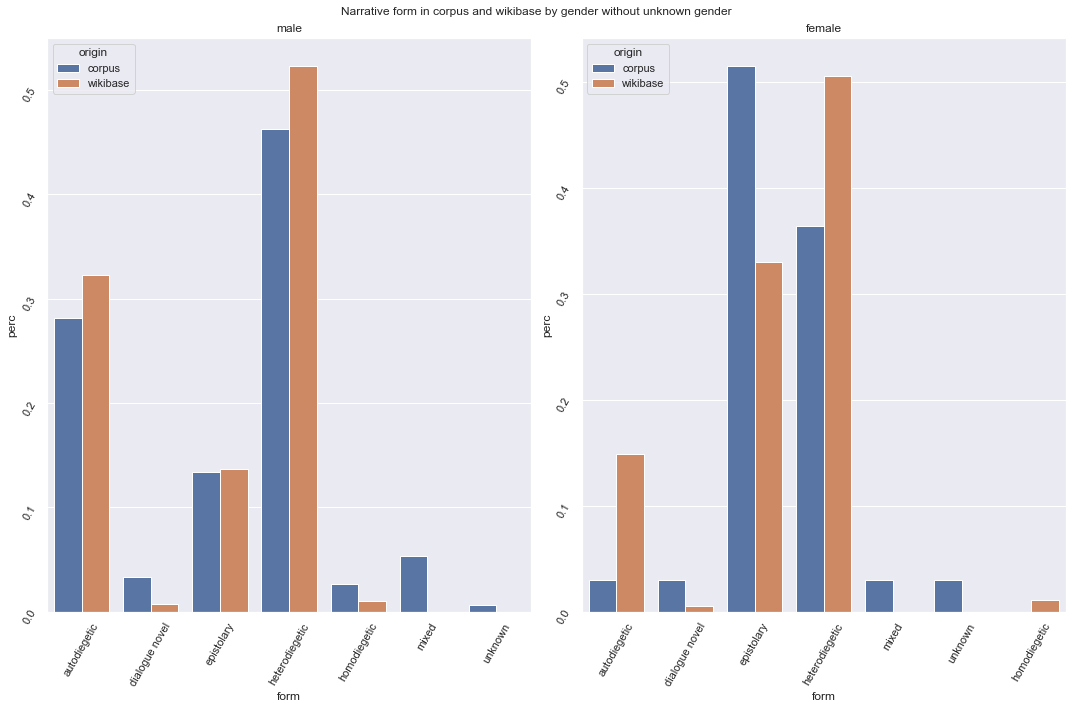

In [132]:
authors_gender_narr_without_unknown = authors_gender_narr[authors_gender_narr["gender"] != "unknown"]
print(authors_gender_narr_without_unknown)
authors_gender_narr_without_unknown = authors_gender_narr_without_unknown[["origin", "form", "gender"]].groupby(["origin", "gender"]).value_counts(normalize=True, sort=False).reset_index(name="perc")
#print(authors_gender_narr_without_unknwon_grouped)
fig, axes = plt.subplots(1, 2, figsize=(15,10))
ax1 = sns.barplot(x="form", y="perc",  hue="origin", data=authors_gender_narr_without_unknown[authors_gender_narr_without_unknown["gender"] == "male"], ax=axes[0])
axes[0].set_title("male")
ax2 = sns.barplot(x="form", y="perc",  hue="origin", data=authors_gender_narr_without_unknown[authors_gender_narr_without_unknown["gender"] == "female"], ax=axes[1])
axes[1].set_title("female")

for ax in fig.axes:
    ax.tick_params(rotation=60)
fig.suptitle("Narrative form in corpus and wikibase by gender without unknown gender")
plt.tight_layout()

### Further comparisons

Now let's do some futher comparisons. These will be used internally to check how balanced the corpus is. Therefore we will copy the dataframe once more and drop items that "empty" cells.

In [135]:
wikib = combined[combined["origin"] == "wikibase"][["form", "gender", "decade"]].copy()

wikib = wikib.dropna()

In [136]:
wikib = wikib.groupby(["decade","form", "gender"], dropna=False).value_counts().reset_index(name="counts_wikib")
print(wikib["counts_wikib"].sum())
wikib["anteil_wikibase"] = wikib.apply(lambda x: x.counts_wikib / wikib["counts_wikib"].sum(), axis=1)
wikib = wikib.rename(columns={"dialogue novel": "dialog"})
print(wikib)

984
    decade            form   gender  counts_wikib  anteil_wikibase
0   1750er    autodiegetic   female             4         0.004065
1   1750er    autodiegetic     male            39         0.039634
2   1750er    autodiegetic  unknown            11         0.011179
3   1750er  dialogue novel   female             1         0.001016
4   1750er  dialogue novel     male             1         0.001016
..     ...             ...      ...           ...              ...
59    1800      epistolary     male             4         0.004065
60    1800      epistolary  unknown             2         0.002033
61    1800  heterodiegetic   female             6         0.006098
62    1800  heterodiegetic     male            21         0.021341
63    1800  heterodiegetic  unknown             5         0.005081

[64 rows x 5 columns]


In [137]:
meta = combined[combined["origin"] == "corpus"][["form", "gender", "decade"]].copy()
print("meta: ", len(meta), meta.columns.to_list())

meta = meta.dropna()
print(len(meta))

meta:  187 ['form', 'gender', 'decade']
187


In [138]:
meta = meta.groupby(["decade", "form", "gender"], dropna=False).value_counts().reset_index(name="counts_meta")
print(meta["counts_meta"].sum())
print(meta.head())

187
   decade            form  gender  counts_meta
0  1750er    autodiegetic    male            7
1  1750er  dialogue novel    male            1
2  1750er      epistolary  female            3
3  1750er      epistolary    male            1
4  1750er  heterodiegetic  female            3


In [139]:
meta["anteil_corpus"] = meta.apply(lambda x: x.counts_meta / meta["counts_meta"].sum(), axis=1)

    decade            form   gender  counts_meta  anteil_corpus
0   1750er    autodiegetic     male            7       0.037433
1   1750er  dialogue novel     male            1       0.005348
2   1750er      epistolary   female            3       0.016043
3   1750er      epistolary     male            1       0.005348
4   1750er  heterodiegetic   female            3       0.016043
5   1750er  heterodiegetic     male           11       0.058824
6   1750er  heterodiegetic  unknown            1       0.005348
7   1750er    homodiegetic     male            1       0.005348
8   1750er           mixed     male            3       0.016043
9   1760er    autodiegetic   female            1       0.005348
10  1760er    autodiegetic     male            8       0.042781
11  1760er      epistolary   female            3       0.016043
12  1760er      epistolary     male            2       0.010695
13  1760er  heterodiegetic   female            2       0.010695
14  1760er  heterodiegetic     male     

In [140]:
result = pd.merge(wikib, meta, how="outer", on=["form", "gender", "decade"]).fillna(0)
result

,decade,form,gender,counts_wikib,anteil_wikibase,counts_meta,anteil_corpus
0,1750er,autodiegetic,female,4.0,0.004065,0.0,0.000000
1,1750er,autodiegetic,male,39.0,0.039634,7.0,0.037433
2,1750er,autodiegetic,unknown,11.0,0.011179,0.0,0.000000
3,1750er,dialogue novel,female,1.0,0.001016,0.0,0.000000
4,1750er,dialogue novel,male,1.0,0.001016,1.0,0.005348
...,...,...,...,...,...,...,...
68,1780er,dialogue novel,female,0.0,0.000000,1.0,0.005348
69,1780er,homodiegetic,male,0.0,0.000000,1.0,0.005348
70,1780er,mixed,female,0.0,0.000000,1.0,0.005348
71,1780er,mixed,male,0.0,0.000000,2.0,0.010695


In [141]:
result["result"] = result.apply(lambda x: "too few" if x.anteil_wikibase > x.anteil_corpus else "too many", axis=1)

    decade            form   gender  counts_wikib  anteil_wikibase  \
0   1750er    autodiegetic   female           4.0         0.004065   
1   1750er    autodiegetic     male          39.0         0.039634   
2   1750er    autodiegetic  unknown          11.0         0.011179   
3   1750er  dialogue novel   female           1.0         0.001016   
4   1750er  dialogue novel     male           1.0         0.001016   
..     ...             ...      ...           ...              ...   
68  1780er  dialogue novel   female           0.0         0.000000   
69  1780er    homodiegetic     male           0.0         0.000000   
70  1780er           mixed   female           0.0         0.000000   
71  1780er           mixed     male           0.0         0.000000   
72    1800         unknown     male           0.0         0.000000   

    counts_meta  anteil_corpus    result  
0           0.0       0.000000   too few  
1           7.0       0.037433   too few  
2           0.0       0.000000

In [151]:
resulttest = result.copy()
combined_t = combined.copy()
resulttest

,decade,form,gender,counts_wikib,anteil_wikibase,counts_meta,anteil_corpus,result
0,1750er,autodiegetic,female,4.0,0.004065,0.0,0.000000,too few
1,1750er,autodiegetic,male,39.0,0.039634,7.0,0.037433,too few
2,1750er,autodiegetic,unknown,11.0,0.011179,0.0,0.000000,too few
3,1750er,dialogue novel,female,1.0,0.001016,0.0,0.000000,too few
4,1750er,dialogue novel,male,1.0,0.001016,1.0,0.005348,too many
...,...,...,...,...,...,...,...,...
68,1780er,dialogue novel,female,0.0,0.000000,1.0,0.005348,too many
69,1780er,homodiegetic,male,0.0,0.000000,1.0,0.005348,too many
70,1780er,mixed,female,0.0,0.000000,1.0,0.005348,too many
71,1780er,mixed,male,0.0,0.000000,2.0,0.010695,too many


wikitest 
                       anteil_wikibase                    
gender                         female      male   unknown
decade form                                              
1750er autodiegetic          0.004065  0.039634  0.011179
       dialogue novel        0.001016  0.001016  0.000000
       epistolary            0.004065  0.007114  0.000000
       heterodiegetic        0.020325  0.045732  0.006098
       homodiegetic          0.000000  0.001016  0.002033
       mixed                 0.000000  0.000000  0.000000
1760er autodiegetic          0.007114  0.045732  0.008130
       dialogue novel        0.000000  0.002033  0.000000
       epistolary            0.010163  0.015244  0.003049
       heterodiegetic        0.011179  0.075203  0.009146
       homodiegetic          0.002033  0.001016  0.000000
       mixed                 0.000000  0.000000  0.000000
       unknown               0.000000  0.000000  0.000000
1770er autodiegetic          0.003049  0.034553  0.005081
   

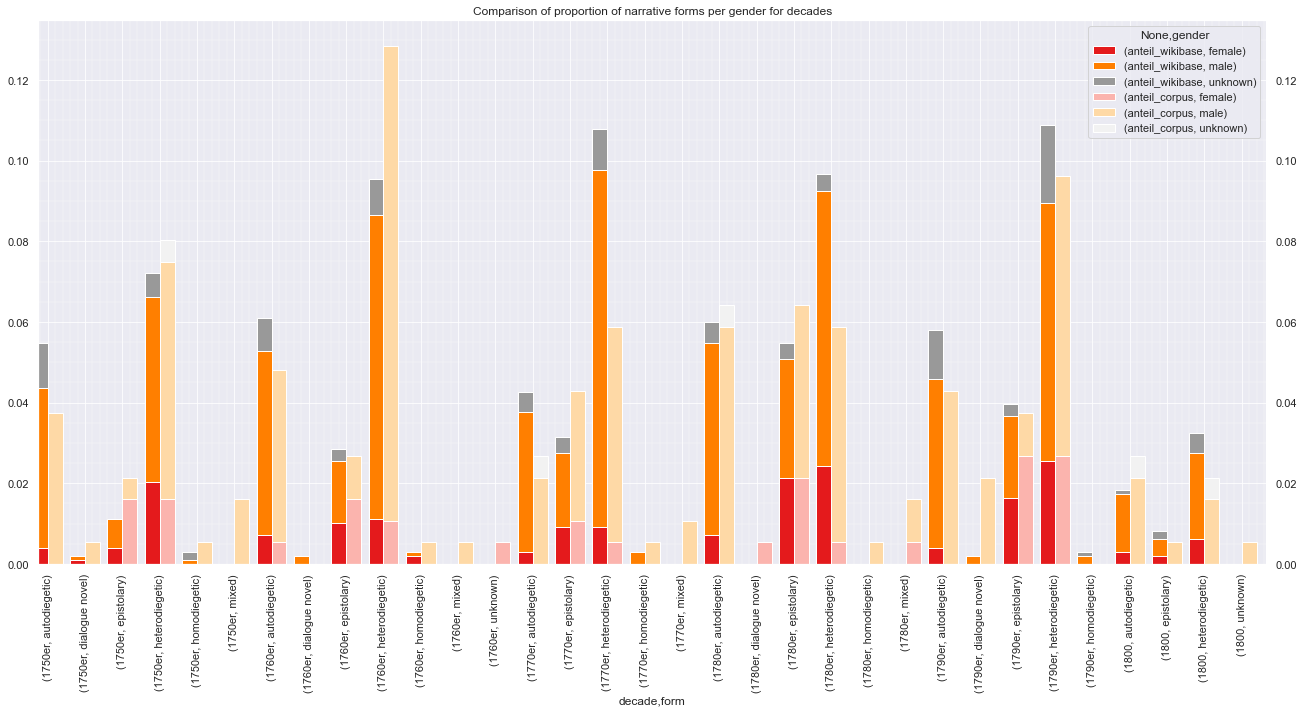

In [152]:
def plot_balancing_years(resulttest, how):
    genders = ["male", "female", "unknown"]
    forms = resulttest["form"].unique()

    resulttest = resulttest.drop(columns=["result", "counts_meta"])

    if how == "outlier_data":
        ## as there are many novels in the wikibase that have only one match for the combination of gender, form and decade, we will drop those
        wikitest = resulttest.copy()
        wikitest["anteil_wikibase"] = wikitest.apply(lambda x: x["anteil_wikibase"] if x["counts_wikib"] > 1 else 0, axis=1)
        wikitest = wikitest.drop(columns=["counts_wikib"])
    elif how == "all_data":
        ## use all_data if you want to visualize all data, including the outliers
        wikitest = resulttest.drop(columns=["counts_wikib"])

    wikitest = wikitest.drop(columns=["anteil_corpus"])
    wikitest = wikitest.pivot_table(index=["decade","form"], columns=["gender"], fill_value=0)
    print("wikitest", "\n", wikitest)
    corpusresulttest = resulttest.drop(columns=["anteil_wikibase", "counts_wikib"])
    corpusresulttest = corpusresulttest.pivot_table(index=["decade","form"], columns=["gender"], fill_value=0)
    print("corpusresulttest", "\n", corpusresulttest)

    # plotting
    fig, ax = plt.subplots(figsize=(22,10))
    ax.grid(which="major", linewidth=0.8)
    ax.grid(which="minor", linewidth=0.3)
    ax.minorticks_on()
    
    wikitest.plot.bar(stacked=True, position=1, width=0.4, ax= ax, colormap="Set1")
    ax.tick_params(labelright=True)

    ax1 = corpusresulttest.plot.bar(stacked=True, ax=ax, position=0, width=0.4, colormap="Pastel1")
    plt.title("Comparison of proportion of narrative forms per gender for decades")

decades = combined_t["decade"].unique()
how = ["all_data", "outlier_data"]
plot_balancing_years(resulttest, how[0])